# **Forecasting S&P 500 using macroeconomic data**

---





> ## **Code**

> ### Import Packages


In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from IPython.display import display, clear_output
from sklearn import preprocessing
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Input
import xgboost
from sklearn.ensemble import AdaBoostRegressor
from datetime import date
import yfinance as yf

sns.set()
%matplotlib inline

In [3]:
!pip install --upgrade tweepy

> ### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/


/content/drive/My Drive


In [ ]:
stockDf=pd.read_csv('merged data.csv')

In [ ]:
stockDf=stockDf.dropna()

In [ ]:
stockDf.shape

(2599, 8)

In [ ]:
stockDf=stockDf.rename(columns={'DATE':'Date'})

In [ ]:
stockDf.head()

,Date,gold price,SP500,USD index,WTI,3 month treasury,10 year treasury,SP500_lagged
1,2024-04-05,"2,329.50",5204.34,121.3671,87.69,5.43,4.39,5202.39
2,2024-04-04,"2,289.43",5147.21,121.1646,87.37,5.41,4.31,5204.34
3,2024-04-03,"2,299.17",5211.49,121.4129,86.22,5.42,4.36,5147.21
4,2024-04-02,"2,280.10",5205.81,121.6881,85.95,5.42,4.36,5211.49
5,2024-04-01,"2,250.36",5243.77,121.8884,84.54,5.44,4.33,5205.81


> ### Basic EDA and Preprocessing

In [ ]:
stockDf["Date"] = stockDf["Date"].astype("datetime64[ns]")
# niftyDf["Date"] = niftyDf["Date"].astype("datetime64[ns]")
# sensexDf["Date"] = sensexDf["Date"].astype("datetime64[ns]")
stockDf = stockDf.set_index("Date")

In [ ]:
stockDf['gold price']=stockDf['gold price'].astype(str).str.replace(',','')

In [ ]:
stockDf['gold price']=stockDf['gold price'].astype(float)

In [ ]:
stockDf.head()

,gold price,SP500,USD index,WTI,3 month treasury,10 year treasury,SP500_lagged
Date,,,,,,,
2024-04-05,2329.50,5204.34,121.3671,87.69,5.43,4.39,5202.39
2024-04-04,2289.43,5147.21,121.1646,87.37,5.41,4.31,5204.34
2024-04-03,2299.17,5211.49,121.4129,86.22,5.42,4.36,5147.21
2024-04-02,2280.10,5205.81,121.6881,85.95,5.42,4.36,5211.49
2024-04-01,2250.36,5243.77,121.8884,84.54,5.44,4.33,5205.81


In [ ]:
stockDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2599 entries, 2024-04-05 to 2014-04-14
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gold price        2599 non-null   float64
 1   SP500             2599 non-null   float64
 2   USD index         2599 non-null   float64
 3   WTI               2599 non-null   float64
 4   3 month treasury  2599 non-null   float64
 5   10 year treasury  2599 non-null   float64
 6   SP500_lagged      2599 non-null   float64
dtypes: float64(7)
memory usage: 162.4 KB


In [ ]:
# Filling Missing Values using Pandas' interpolate method
stockDf.interpolate(inplace=True, method='time')
# niftyDf.interpolate(inplace=True, method='time')
# sensexDf.interpolate(inplace=True, method='time')

Text(0.5, 1.0, 'Data Correlations')

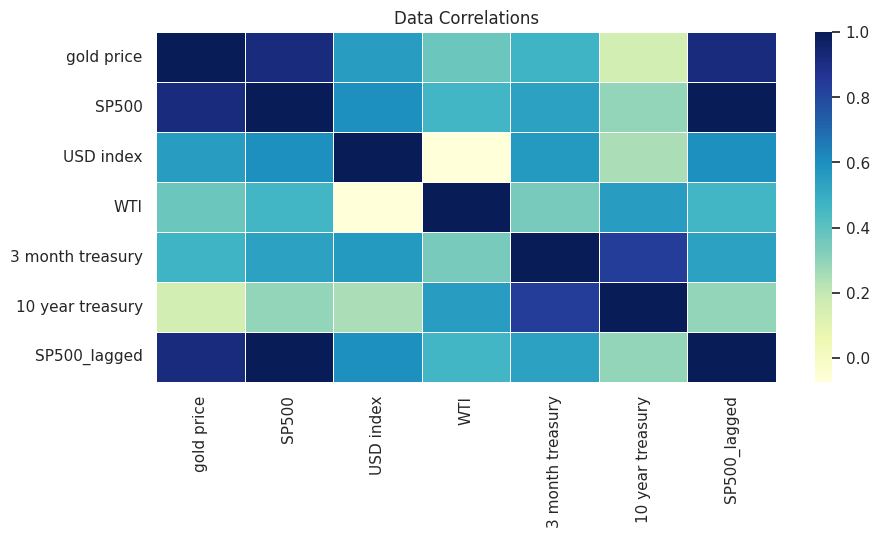

In [ ]:
# Correlation Heatmaps of Nifty and Sensex Features
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1)
sns.heatmap(stockDf.corr(), linewidths=.5, cmap="YlGnBu", ax=ax).set_title("Data Correlations")
# ax = fig.add_subplot(2, 1, 2)
# sns.heatmap(sensexDf.corr(), linewidths=.5, cmap="YlGnBu", ax=ax).set_title("Sensex Data Correlations")


In [ ]:
stockDf=stockDf.rename(columns={'gold price':'Gold','USD index':'USD_Index','3 month treasury':'3_month_treasury','10 year treasury':'10_year_treasury'})

In [ ]:
# Inner Join on Datasets
# niftyTempDf = niftyDf[["Close"]].rename(columns={"Close":"Nifty_Close"})
# sensexTempDf = sensexDf[["Close"]].rename(columns={"Close":"Sensex_Close"})
df = stockDf.dropna()
df = df = df.sort_index(ascending=True)
df.head()

,Gold,SP500,USD_Index,WTI,3_month_treasury,10_year_treasury,SP500_lagged
Date,,,,,,,
2014-04-14,1326.40,1862.31,93.8046,104.05,0.04,2.65,1862.31
2014-04-15,1302.65,1862.31,93.9486,103.70,0.04,2.64,1862.31
2014-04-16,1302.80,1862.31,93.9461,103.71,0.04,2.65,1864.85
2014-04-17,1294.85,1864.85,93.8936,104.33,0.03,2.73,1871.89
2014-04-18,1293.78,1871.89,93.9629,104.35,0.04,2.73,1871.89


In [ ]:
df.corr()

,Gold,SP500,USD_Index,WTI,3_month_treasury,10_year_treasury,SP500_lagged
Gold,1.000000,0.916227,0.556753,0.372033,0.469807,0.156462,0.916529
SP500,0.916227,1.000000,0.600977,0.463268,0.539974,0.294344,0.999308
USD_Index,0.556753,0.600977,1.000000,-0.073221,0.565499,0.245537,0.601290
WTI,0.372033,0.463268,-0.073221,1.000000,0.345757,0.554526,0.461959
3_month_treasury,0.469807,0.539974,0.565499,0.345757,1.000000,0.834236,0.540244
10_year_treasury,0.156462,0.294344,0.245537,0.554526,0.834236,1.000000,0.293788
SP500_lagged,0.916529,0.999308,0.601290,0.461959,0.540244,0.293788,1.000000


> ### Basic Visualizations

1. Scatter Plots
2. Correlation Map
3. Time Series Plots

<Axes: >

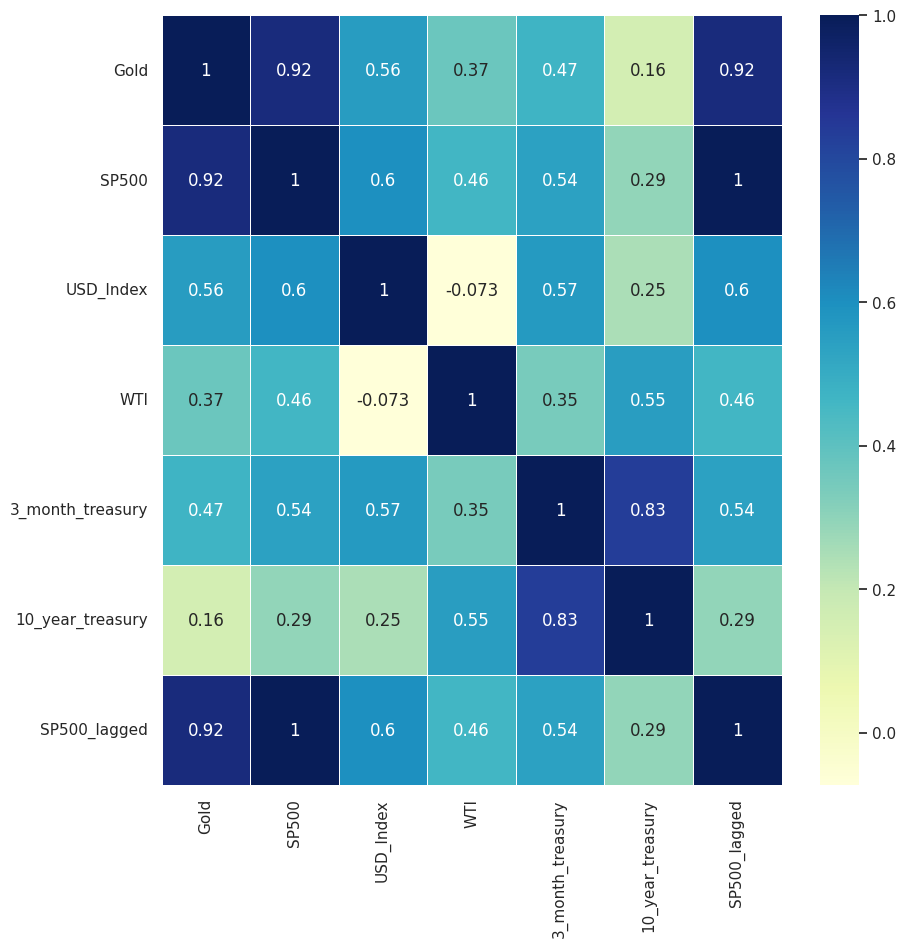

In [ ]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(df.corr(), linewidths=.5, cmap="YlGnBu", ax=ax, annot=True)

In [ ]:
df.columns

Index(['Gold', 'SP500', 'USD_Index', 'WTI', '3_month_treasury',
       '10_year_treasury', 'SP500_lagged'],
      dtype='object')

<Axes: xlabel='WTI', ylabel='SP500_lagged'>

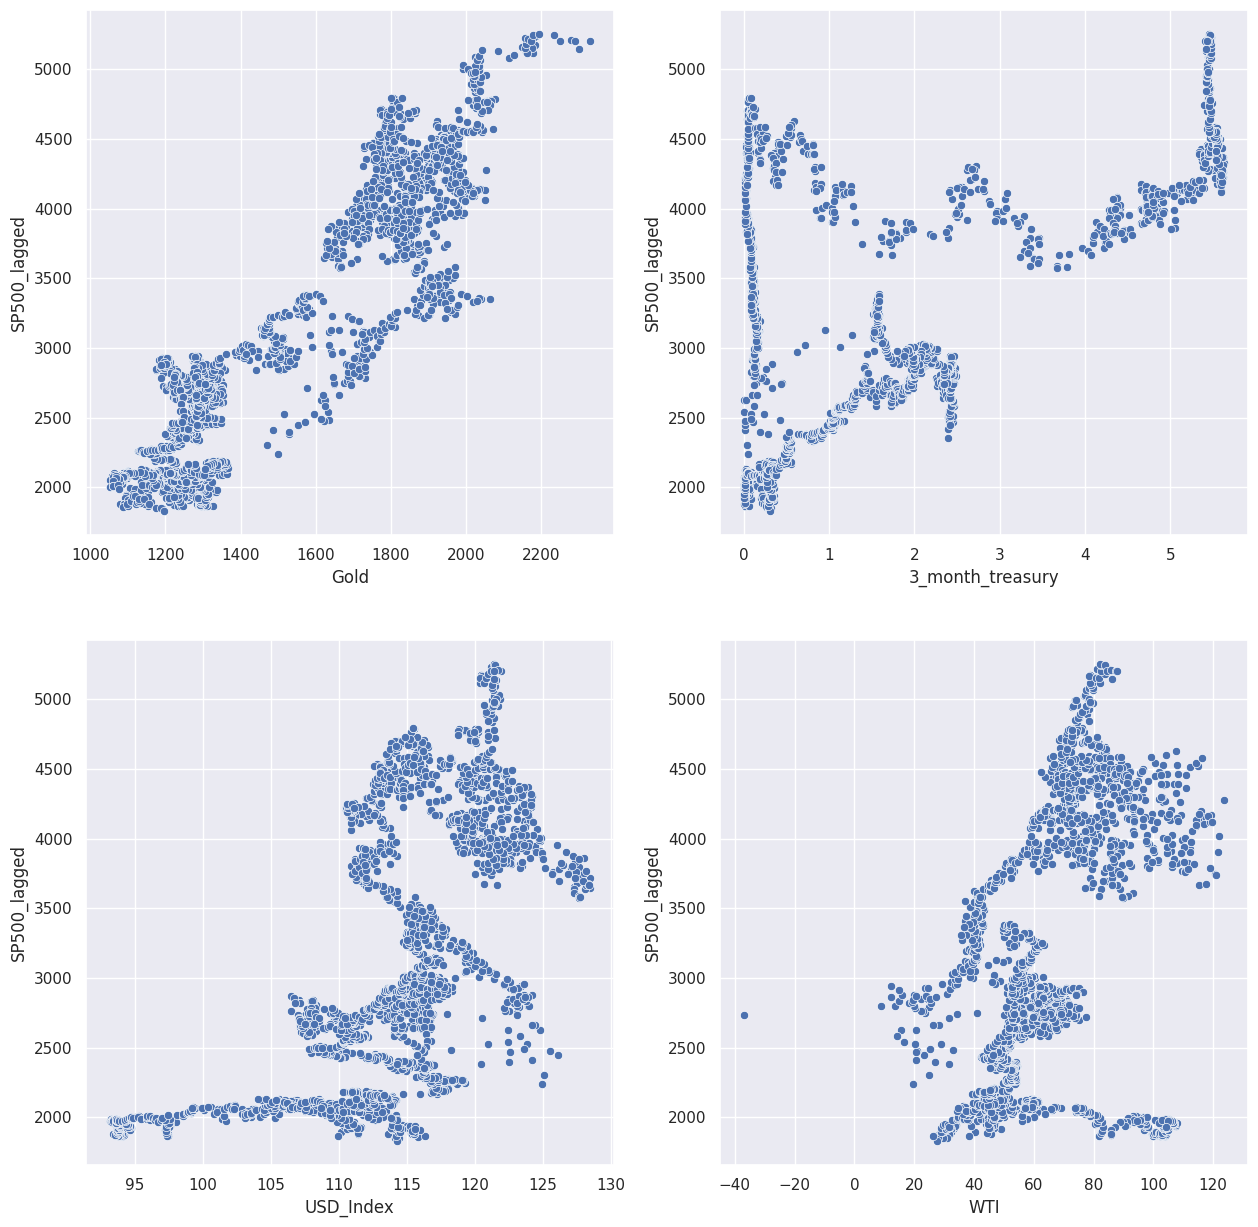

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="Gold", y="SP500_lagged", data=df)
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="3_month_treasury", y="SP500_lagged", data=df)
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="USD_Index", y="SP500_lagged", data=df)
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="WTI", y="SP500_lagged", data=df)

<ipython-input-53-144ebb1f3a49>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SP500_lagged']).set_title("Closing Price Distribution of Stock")
<ipython-input-53-144ebb1f3a49>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Gold']).set_title("Gold Price Distribution")
<ipython-input-5

Text(0.5, 1.0, 'Crude Price Distribution')

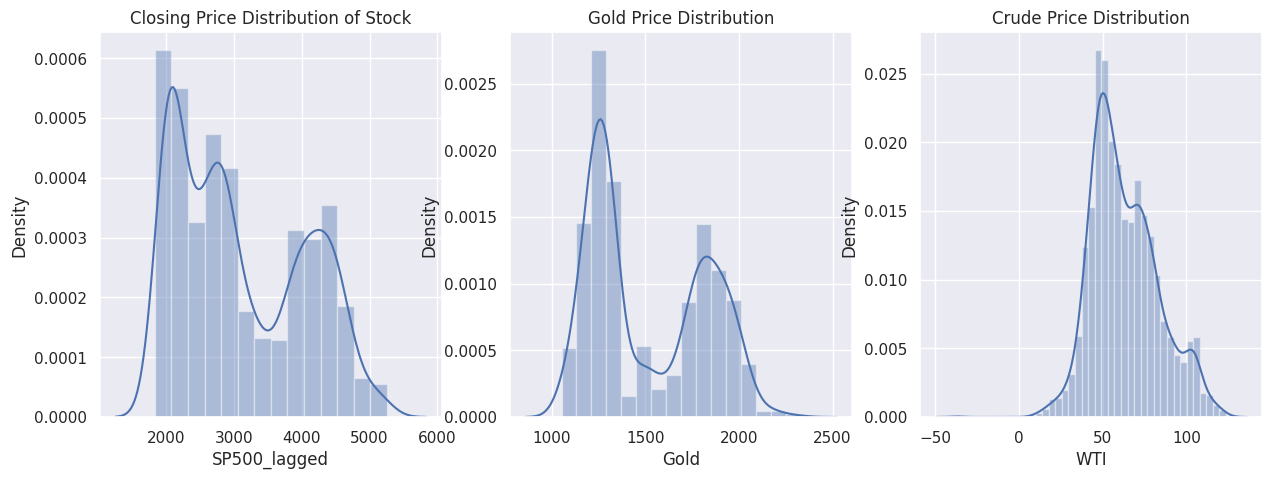

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1)
sns.distplot(df['SP500_lagged']).set_title("Closing Price Distribution of Stock")
ax = fig.add_subplot(1, 3, 2)
sns.distplot(df['Gold']).set_title("Gold Price Distribution")
ax = fig.add_subplot(1, 3, 3)
sns.distplot(df['WTI']).set_title("Crude Price Distribution")

In [ ]:
currMonth = df.index[0].month
positions = []
for p in df.index:
  if p.month!=currMonth:
    currMonth = p.month
    positions.append(p)

labels = [l.strftime('20%y-%m') for l in positions]
# ax = df.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(28,10))
# df.reset_index().plot(x="Date", y="3_month_treasury", ax=ax, legend=False, color="r")
# ax.set_xticks(positions)
# ax.set_xticklabels(labels)
# plt.xticks(rotation='vertical')
# ax.set_title("SP500 & 3 month Treasuries")
# ax.figure.legend()
# plt.show()

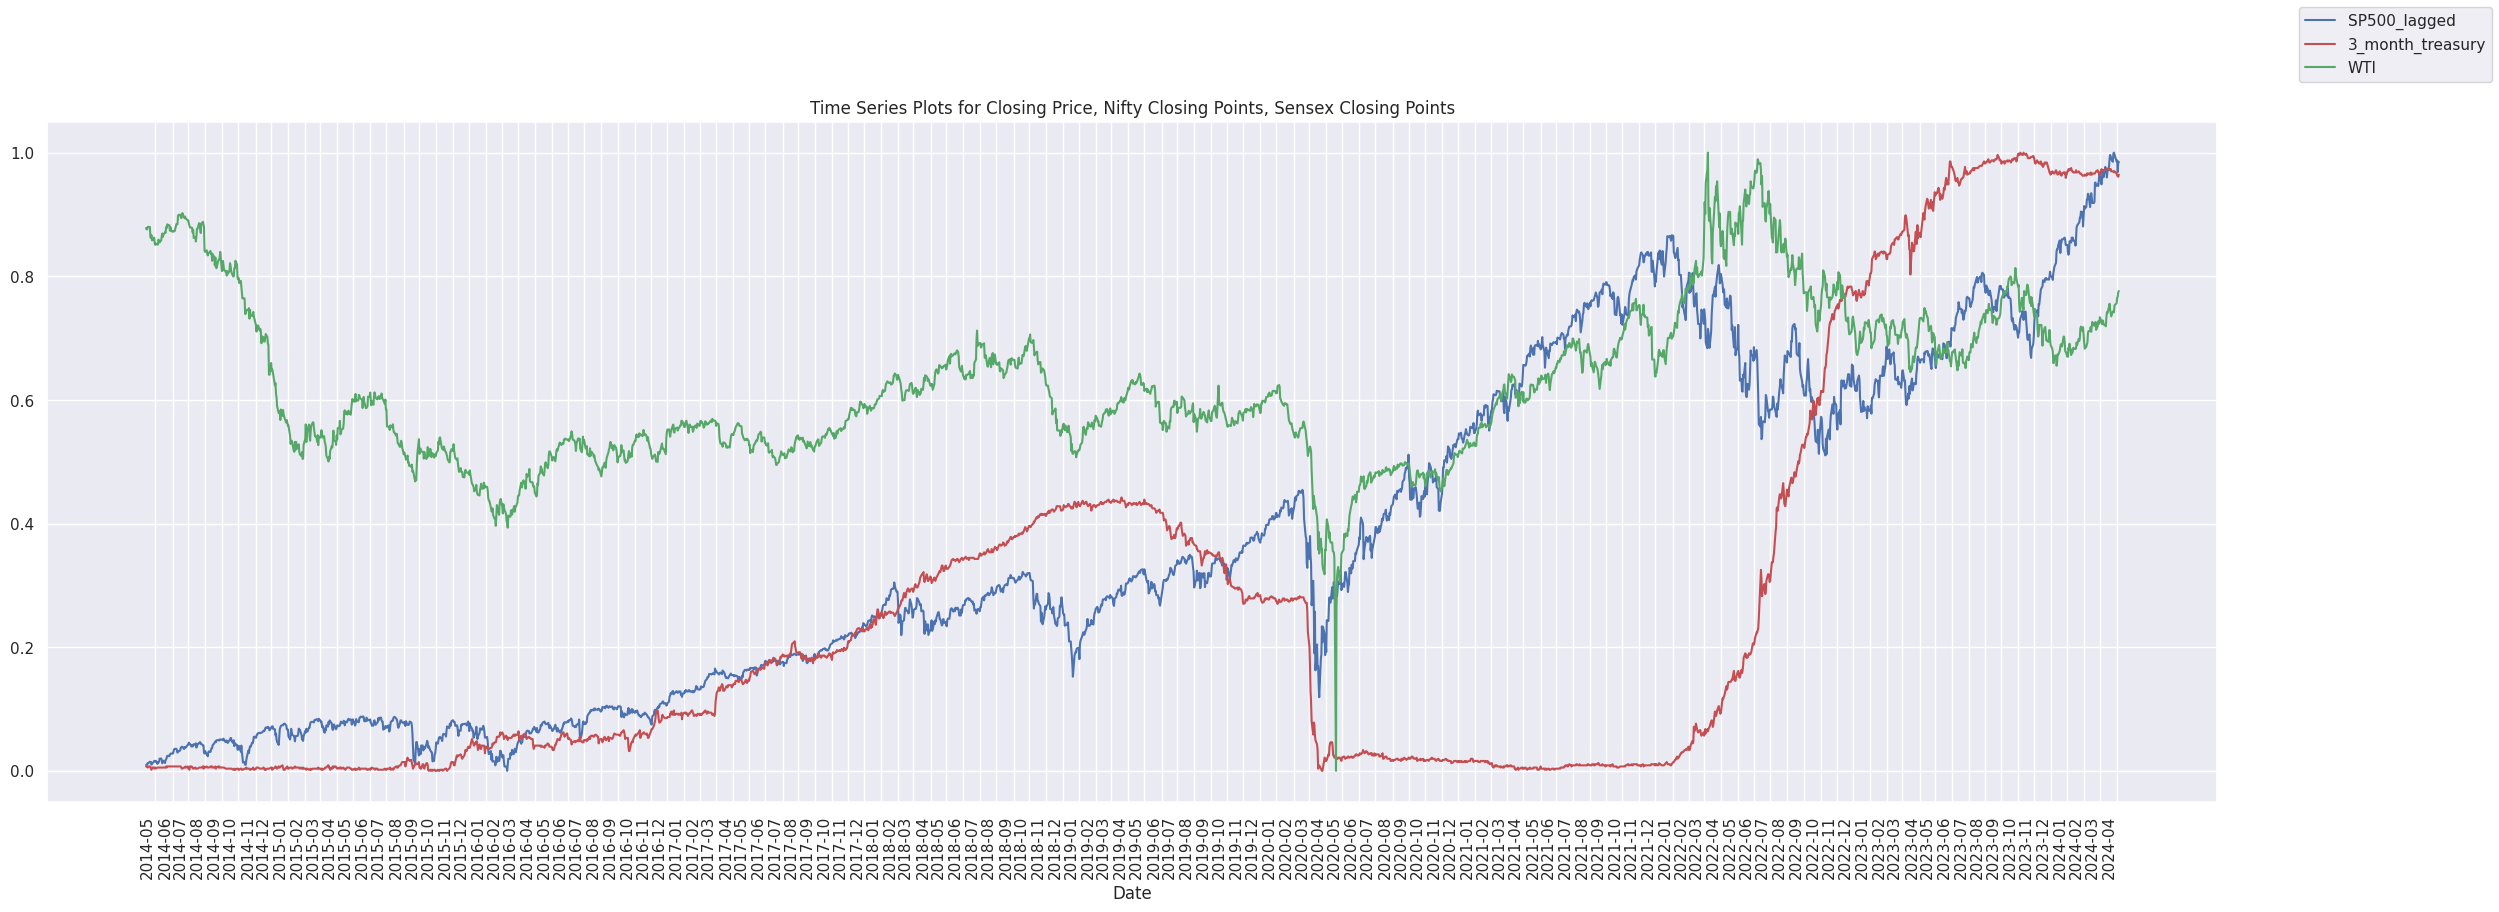

In [ ]:
normalizedDf = df[["SP500_lagged", "3_month_treasury", "WTI"]]
x = normalizedDf.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalizedDf = pd.DataFrame(x_scaled)
normalizedDf["Date"] = df.index
normalizedDf = normalizedDf.rename(columns={0: "SP500_lagged", 1:"3_month_treasury", 2: "WTI"})
normalizedDf.head()
ax = normalizedDf.plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(28,10))
normalizedDf.reset_index().plot(x="Date", y="3_month_treasury", ax=ax, legend=False, color="r")
normalizedDf.reset_index().plot(x="Date", y="WTI", ax=ax, legend=False, color="g")
ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.xticks(rotation='vertical')
ax.set_title("Time Series Plots for Closing Price, Nifty Closing Points, Sensex Closing Points")
ax.figure.legend()
plt.show()

> ### Feature Engineering using Technical Indicators


#### 1. Moving Average
Smoothens the Price data, Cuts down noise. It helps to showcase the increasing or decreasing trend of the stock

In [ ]:
movingAvgDf = pd.DataFrame(df)
ma_day=[20, 50, 100]
for ma in ma_day:
    column_name = f"MA_{ma}_days"
    movingAvgDf[column_name] = movingAvgDf['SP500_lagged'].rolling(ma).mean()
movingAvgDf.dropna(inplace=True)
movingAvgDf.head()

,Gold,SP500,USD_Index,WTI,3_month_treasury,10_year_treasury,SP500_lagged,MA_20_days,MA_50_days,MA_100_days
Date,,,,,,,,,,
2014-08-29,1287.57,2003.37,94.7251,97.86,0.03,2.35,2002.28,1966.5155,1967.3644,1935.2807
2014-09-01,1287.30,2002.28,95.0630,92.92,0.03,2.42,2002.28,1970.6190,1968.4104,1936.6804
2014-09-02,1265.90,2002.28,95.0630,92.92,0.03,2.42,2000.72,1974.6430,1969.2342,1938.0645
2014-09-03,1269.07,2000.72,94.8709,95.50,0.03,2.41,1997.65,1979.0470,1970.0428,1939.3925
2014-09-04,1261.10,1997.65,95.2641,94.51,0.03,2.45,2007.71,1982.8530,1970.9778,1940.7507


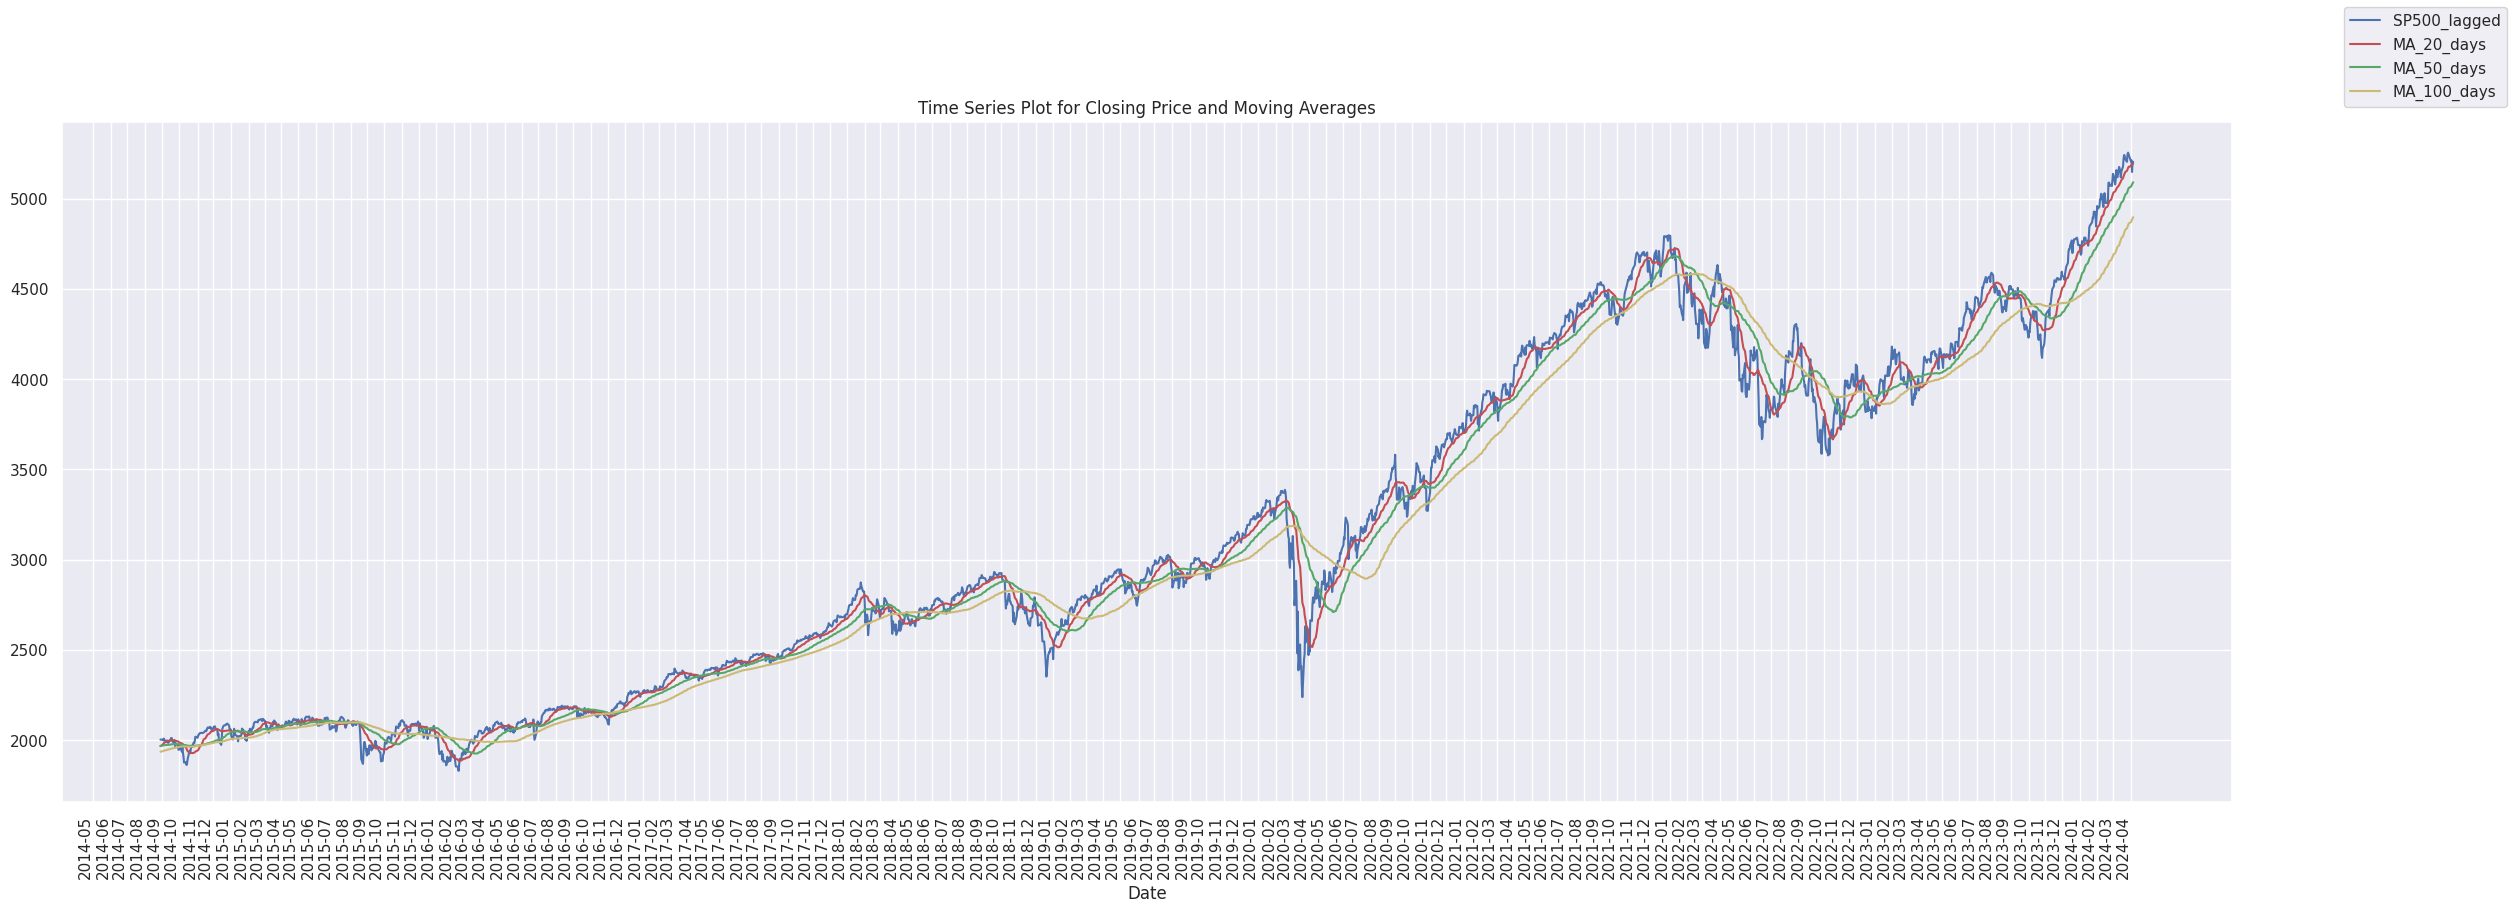

In [ ]:
currMonth = df.index[0].month
positions = []
for p in df.index:
  if p.month!=currMonth:
    currMonth = p.month
    positions.append(p)
labels = [l.strftime('20%y-%m') for l in positions]
ax = movingAvgDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(28,10))
movingAvgDf.reset_index().plot(x="Date", y="MA_20_days", ax=ax, legend=False, color="r")
movingAvgDf.reset_index().plot(x="Date", y="MA_50_days", ax=ax, legend=False, color="g")
movingAvgDf.reset_index().plot(x="Date", y="MA_100_days", ax=ax, legend=False, color="y")
ax.set_xticks(positions)
ax.set_xticklabels(labels)
plt.xticks(rotation='vertical')
ax.set_title("Time Series Plot for Closing Price and Moving Averages")
ax.figure.legend()
plt.show()

<Axes: xlabel='MA_50_days', ylabel='SP500_lagged'>

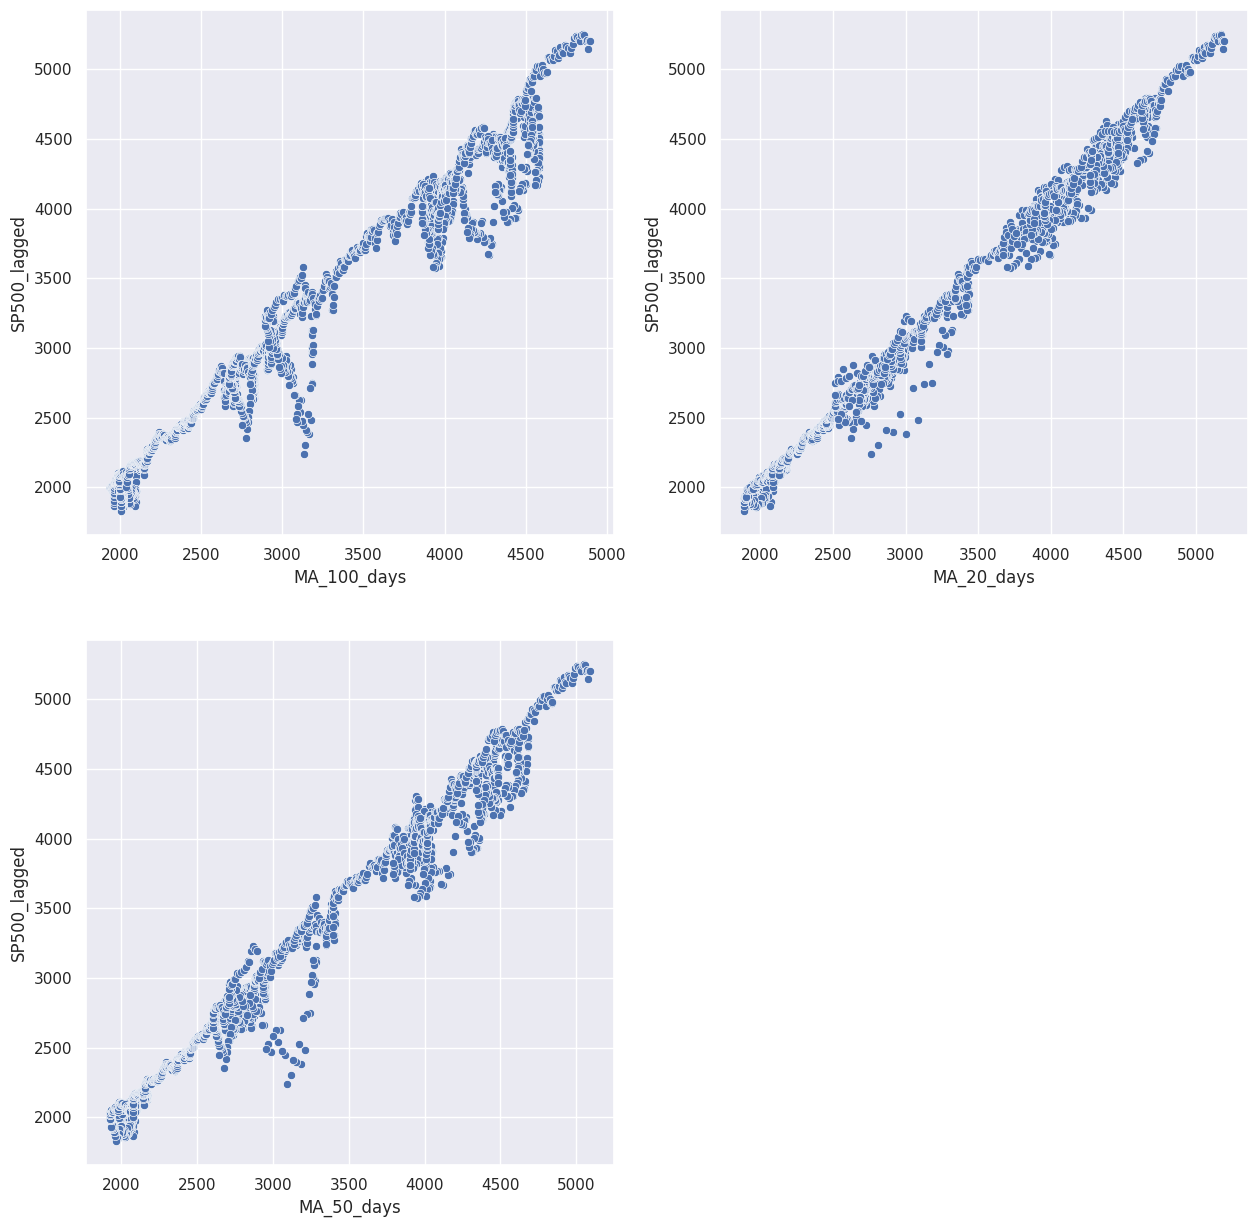

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="MA_100_days", y="SP500_lagged", data=movingAvgDf)
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="MA_20_days", y="SP500_lagged", data=movingAvgDf)
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="MA_50_days", y="SP500_lagged", data=movingAvgDf)


#### 2. Return Deviation
To Determine Risk and Return

Text(0.5, 1.0, 'Return Rate of Stock')

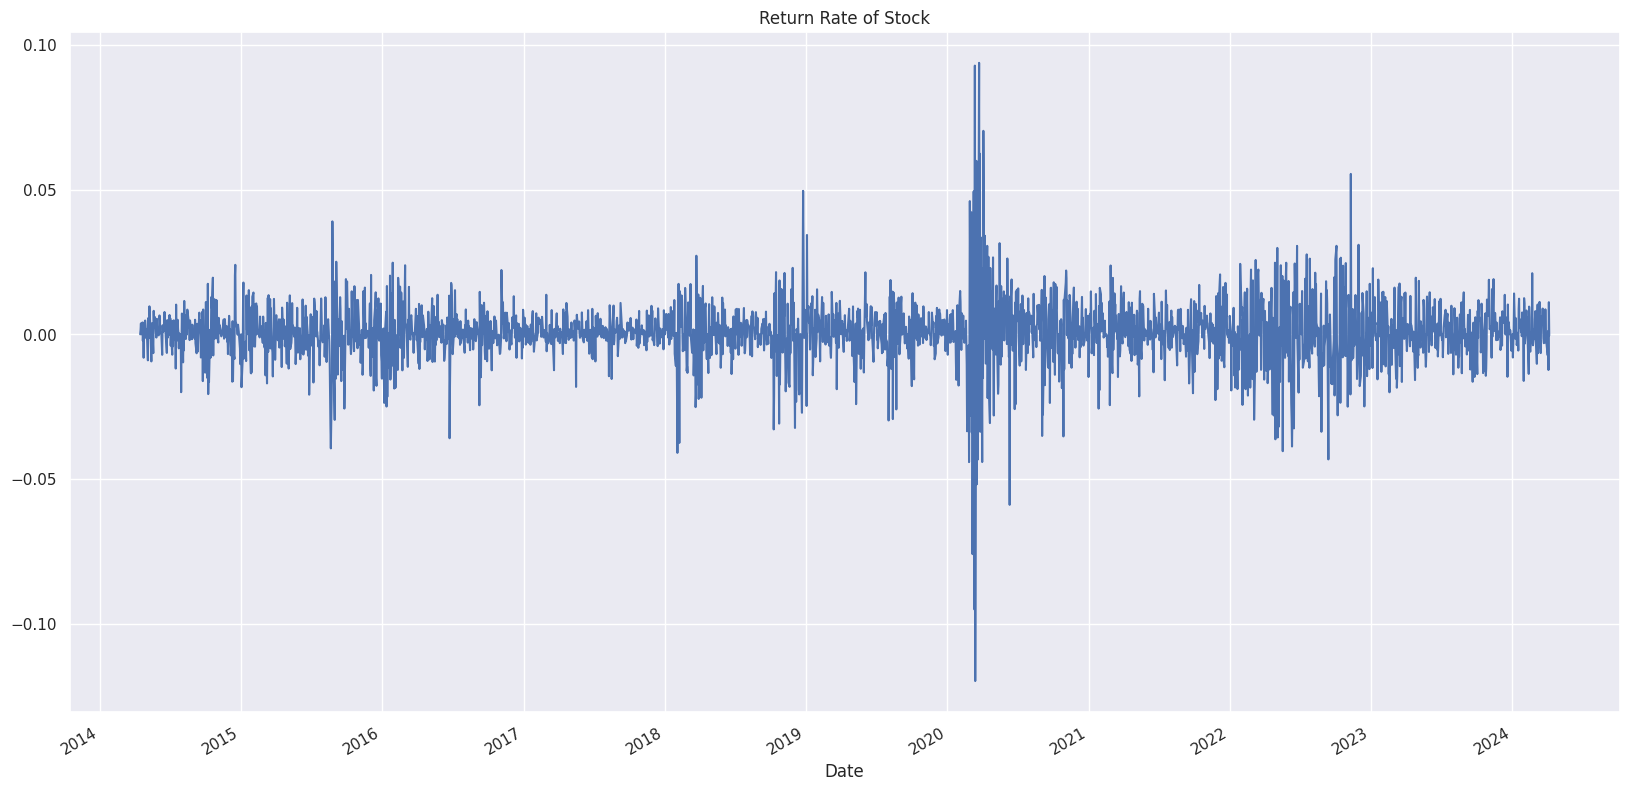

In [ ]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
closing = df["SP500_lagged"]
rets = closing/closing.shift(1) - 1
rets.plot(label="return", ax=ax).set_title("Return Rate of Stock")

> ### Model Building

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
# Creating Dataframe for model training
modelDf = movingAvgDf
modelDf.head()

,Gold,SP500,USD_Index,WTI,3_month_treasury,10_year_treasury,SP500_lagged,MA_20_days,MA_50_days,MA_100_days
Date,,,,,,,,,,
2014-08-29,1287.57,2003.37,94.7251,97.86,0.03,2.35,2002.28,1966.5155,1967.3644,1935.2807
2014-09-01,1287.30,2002.28,95.0630,92.92,0.03,2.42,2002.28,1970.6190,1968.4104,1936.6804
2014-09-02,1265.90,2002.28,95.0630,92.92,0.03,2.42,2000.72,1974.6430,1969.2342,1938.0645
2014-09-03,1269.07,2000.72,94.8709,95.50,0.03,2.41,1997.65,1979.0470,1970.0428,1939.3925
2014-09-04,1261.10,1997.65,95.2641,94.51,0.03,2.45,2007.71,1982.8530,1970.9778,1940.7507


In [ ]:
modelDf["DateNum"] = modelDf.index.map(mdates.date2num)
modelDf.head()

,Gold,SP500,USD_Index,WTI,3_month_treasury,10_year_treasury,SP500_lagged,MA_20_days,MA_50_days,MA_100_days,DateNum
Date,,,,,,,,,,,
2014-08-29,1287.57,2003.37,94.7251,97.86,0.03,2.35,2002.28,1966.5155,1967.3644,1935.2807,16311.0
2014-09-01,1287.30,2002.28,95.0630,92.92,0.03,2.42,2002.28,1970.6190,1968.4104,1936.6804,16314.0
2014-09-02,1265.90,2002.28,95.0630,92.92,0.03,2.42,2000.72,1974.6430,1969.2342,1938.0645,16315.0
2014-09-03,1269.07,2000.72,94.8709,95.50,0.03,2.41,1997.65,1979.0470,1970.0428,1939.3925,16316.0
2014-09-04,1261.10,1997.65,95.2641,94.51,0.03,2.45,2007.71,1982.8530,1970.9778,1940.7507,16317.0


In [ ]:
modelDf=modelDf.sort_index(ascending=True)

In [ ]:
modelDf=clean_dataset(modelDf)

In [ ]:
modelDf.head()

,Gold,SP500,USD_Index,WTI,3_month_treasury,10_year_treasury,SP500_lagged,MA_20_days,MA_50_days,MA_100_days,DateNum
Date,,,,,,,,,,,
2014-08-29,1287.57,2003.37,94.7251,97.86,0.03,2.35,2002.28,1966.5155,1967.3644,1935.2807,16311.0
2014-09-01,1287.30,2002.28,95.0630,92.92,0.03,2.42,2002.28,1970.6190,1968.4104,1936.6804,16314.0
2014-09-02,1265.90,2002.28,95.0630,92.92,0.03,2.42,2000.72,1974.6430,1969.2342,1938.0645,16315.0
2014-09-03,1269.07,2000.72,94.8709,95.50,0.03,2.41,1997.65,1979.0470,1970.0428,1939.3925,16316.0
2014-09-04,1261.10,1997.65,95.2641,94.51,0.03,2.45,2007.71,1982.8530,1970.9778,1940.7507,16317.0


In [ ]:
modelDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2014-08-29 to 2024-04-05
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gold              2500 non-null   float64
 1   SP500             2500 non-null   float64
 2   USD_Index         2500 non-null   float64
 3   WTI               2500 non-null   float64
 4   3_month_treasury  2500 non-null   float64
 5   10_year_treasury  2500 non-null   float64
 6   SP500_lagged      2500 non-null   float64
 7   MA_20_days        2500 non-null   float64
 8   MA_50_days        2500 non-null   float64
 9   MA_100_days       2500 non-null   float64
 10  DateNum           2500 non-null   float64
dtypes: float64(11)
memory usage: 234.4 KB


In [ ]:
# Train Test Split (60:20:20)
train_end = int(len(modelDf)*0.8)
val_end = int(len(modelDf)*0.8)
trainDf = modelDf.loc[modelDf.index[:train_end]]
valDf = modelDf.loc[modelDf.index[train_end:]]
print("Train Date Range: ", trainDf.index[0].date(), ":",trainDf.index[-1].date())
print("Validation Date Range: ", valDf.index[0].date(), ":",valDf.index[-1].date())

Train Date Range:  2014-08-29 : 2022-05-04
Validation Date Range:  2022-05-05 : 2024-04-05


In [ ]:
trainX, trainY = trainDf.drop("SP500_lagged", axis=1).values, trainDf[["SP500_lagged"]].values
valX, valY = valDf.drop("SP500_lagged", axis=1).values, valDf[["SP500_lagged"]].values

In [ ]:
np.any(np.isnan(trainX)), np.any(np.isnan(trainY)), np.any(np.isnan(valX)), np.any(np.isnan(valY))

(False, False, False, False)

In [ ]:
np.all(np.isfinite(trainX)),np.all(np.isfinite(trainY)),np.all(np.isfinite(valX)),np.all(np.isfinite(valY))

(True, True, True, True)

In [ ]:
scX = StandardScaler()
scY = StandardScaler()
trainX = scX.fit_transform(trainX)
trainY = scY.fit_transform(trainY)
valX = scX.transform(valX)
valY = scY.transform(valY)

In [ ]:
# ML Models (Linear Regression, SVR, RandomForest Regressor, XGBoost, KNN Regression)

RMSE Train: 32.56750827509018
RMSE Test: 50.99771322001575
R2 Train: 0.9983322967420288
R2 Test: 0.9834813694437647



Text(0.5, 1.0, 'Linear Regression Prediction')

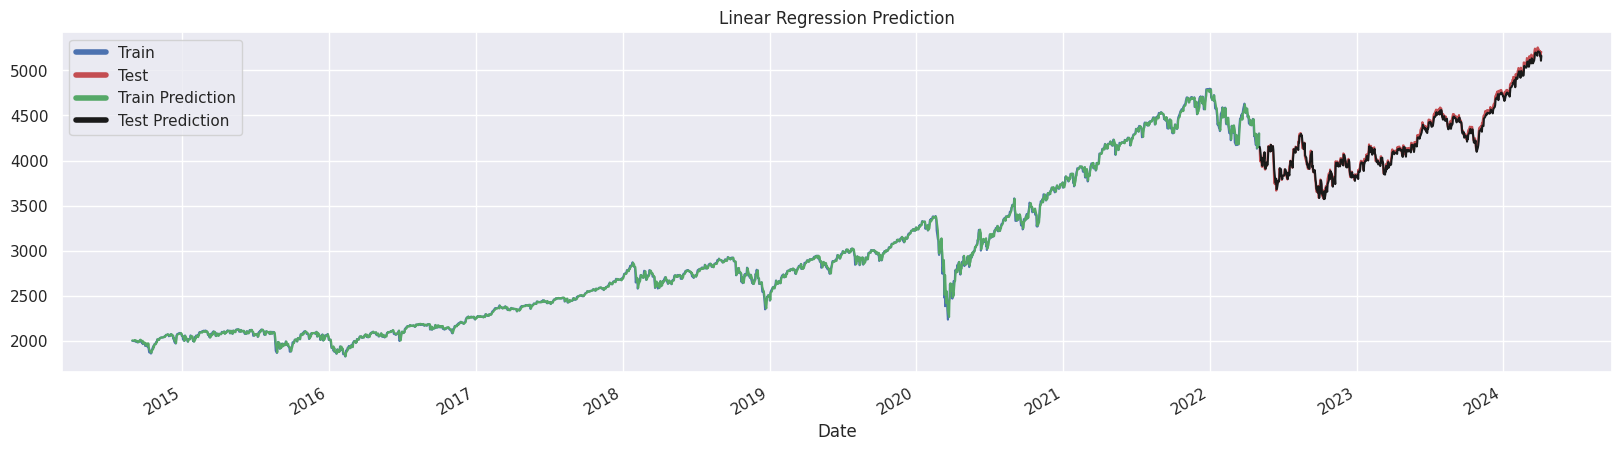

In [ ]:
# 1. Linear Regression
reg = LinearRegression().fit(trainX, trainY)
predVal = reg.predict(valX)
predTrain = reg.predict(trainX)

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='k', lw=4)]

# print("RMSE Train:", math.sqrt(mean_squared_error(trainY, predTrain)))
# print("RMSE Test:", math.sqrt(mean_squared_error(valY, predVal)))
# print("R2 Train:", r2_score(trainY, predTrain))
# print("R2 Test:", r2_score(valY, predVal))
# print()
trainDf["Predicted"] = scY.inverse_transform(predTrain)
valDf["Predicted"] = scY.inverse_transform(predVal)

print("RMSE Train:", math.sqrt(mean_squared_error(trainDf["SP500_lagged"], trainDf["Predicted"])))
print("RMSE Test:", math.sqrt(mean_squared_error(valDf["SP500_lagged"], valDf["Predicted"])))
print("R2 Train:", r2_score(trainDf["SP500_lagged"], trainDf["Predicted"]))
print("R2 Test:", r2_score(valDf["SP500_lagged"], valDf["Predicted"]))
print()

ax = trainDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="SP500_lagged", ax=ax, legend=False, color="r")
trainDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="g")
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("Linear Regression Prediction")

Text(0.5, 1.0, 'Linear Regression Prediction on Test Set')

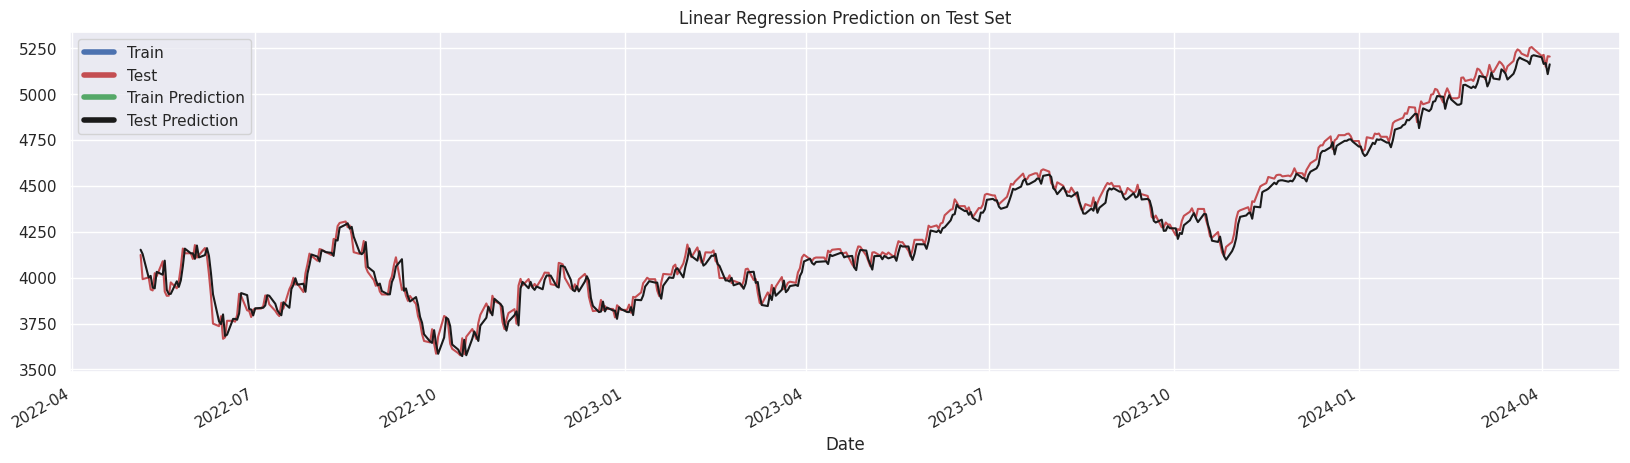

In [ ]:
ax = valDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="r", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("Linear Regression Prediction on Test Set")

RMSE Train: 30.91000221568054
RMSE Test: 500.0322731112476
R2 Train: 0.9984977307240942
R2 Test: -0.5880665799944194



Text(0.5, 1.0, 'Linear Regression with Polynomial Features Prediction')

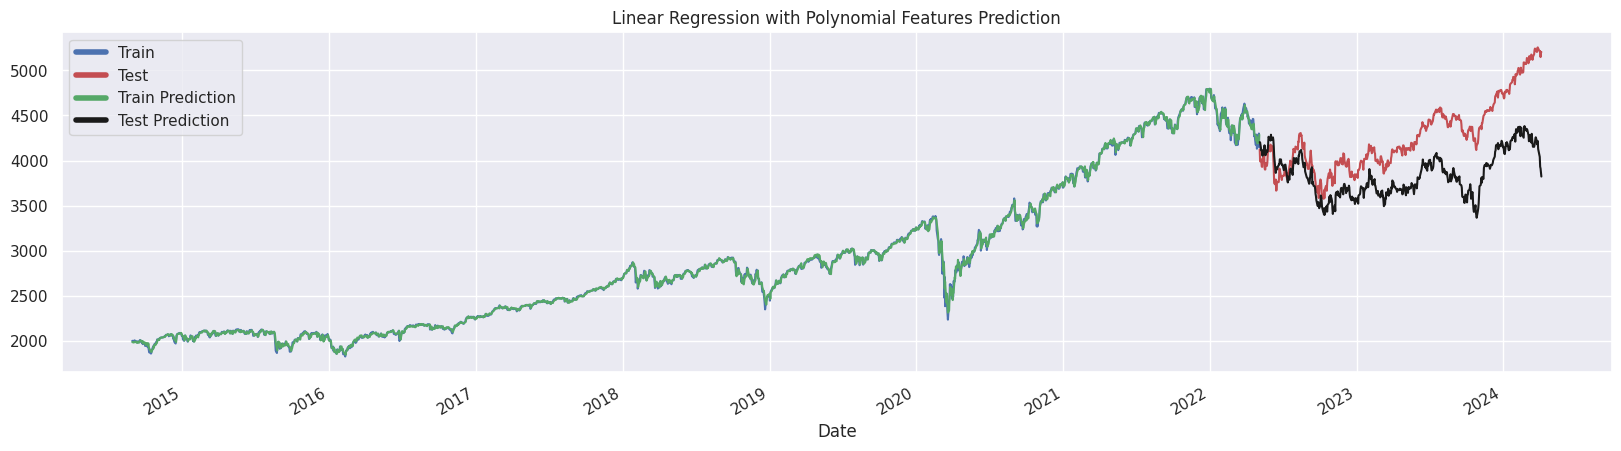

In [ ]:
# 2. Linear Regression with Polynomial Features
reg = make_pipeline(PolynomialFeatures(2), LinearRegression()).fit(trainX, trainY)
predVal = reg.predict(valX)
predTrain = reg.predict(trainX)

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='k', lw=4)]
trainDf["Predicted"] = scY.inverse_transform(predTrain)
valDf["Predicted"] = scY.inverse_transform(predVal)

print("RMSE Train:", math.sqrt(mean_squared_error(trainDf["SP500_lagged"], trainDf["Predicted"])))
print("RMSE Test:", math.sqrt(mean_squared_error(valDf["SP500_lagged"], valDf["Predicted"])))
print("R2 Train:", r2_score(trainDf["SP500_lagged"], trainDf["Predicted"]))
print("R2 Test:", r2_score(valDf["SP500_lagged"], valDf["Predicted"]))
print()

ax = trainDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="SP500_lagged", ax=ax, legend=False, color="r")
trainDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="g")
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("Linear Regression with Polynomial Features Prediction")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE Train: 41.710880718618824
RMSE Test: 70.23708642645484
R2 Train: 0.99726442621743
R2 Test: 0.9686667379323011



Text(0.5, 1.0, 'SVR Prediction')

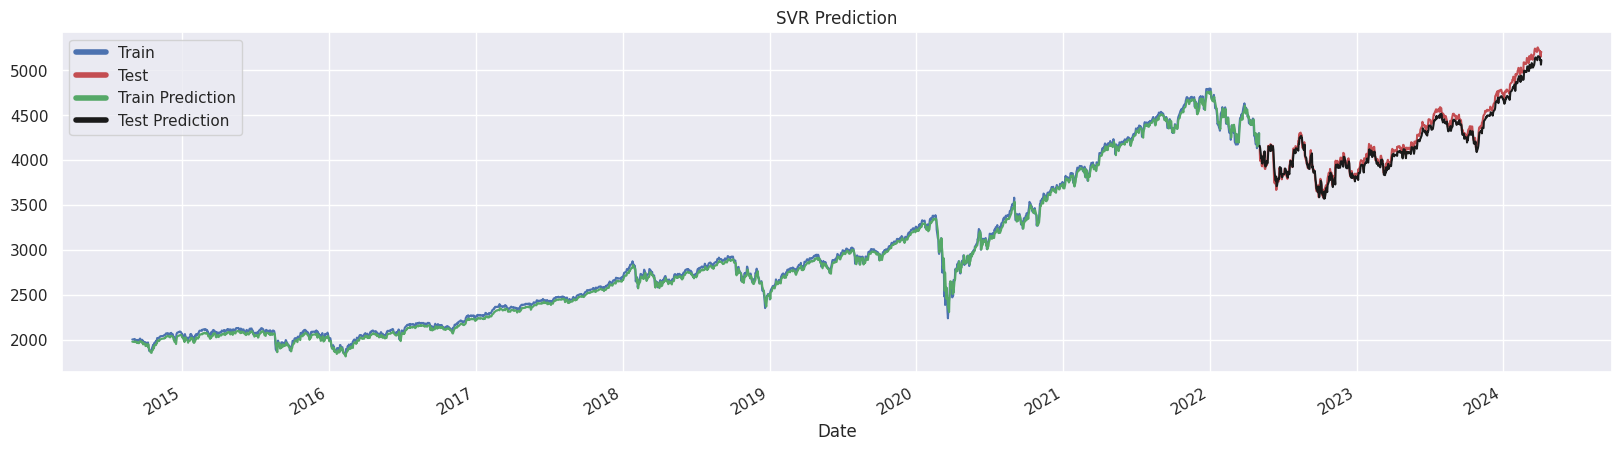

In [ ]:
# 3. SVR
reg = SVR(kernel= 'linear', C= 1000, gamma= 0.01, epsilon=0.1)
reg.fit(trainX, trainY)
predVal = reg.predict(valX)
predTrain = reg.predict(trainX)

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='k', lw=4)]

predTrain = predTrain.reshape(-1, 1)
predVal = predVal.reshape(-1, 1)
trainDf["Predicted"] = scY.inverse_transform(predTrain)
valDf["Predicted"] = scY.inverse_transform(predVal)

print("RMSE Train:", math.sqrt(mean_squared_error(trainDf["SP500_lagged"], trainDf["Predicted"])))
print("RMSE Test:", math.sqrt(mean_squared_error(valDf["SP500_lagged"], valDf["Predicted"])))
print("R2 Train:", r2_score(trainDf["SP500_lagged"], trainDf["Predicted"]))
print("R2 Test:", r2_score(valDf["SP500_lagged"], valDf["Predicted"]))
print()

ax = trainDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="SP500_lagged", ax=ax, legend=False, color="r")
trainDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="g")
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("SVR Prediction")

Text(0.5, 1.0, 'SVR Prediction on Test Set')

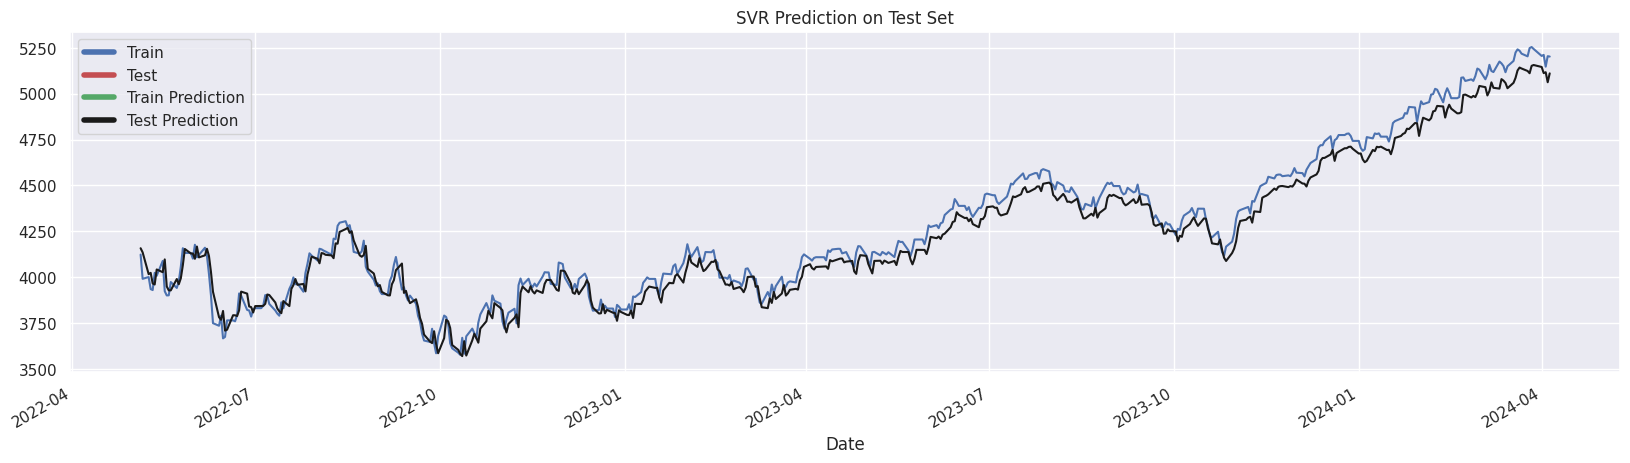

In [ ]:
ax = valDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("SVR Prediction on Test Set")

<ipython-input-78-7a414feb3cfb>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(trainX, trainY)


RMSE Train: 36.740576350010905
RMSE Test: 178.7340188965596
R2 Train: 0.9978775295991094
R2 Test: 0.797097650094513



Text(0.5, 1.0, 'Random Forest Regressor Prediction')

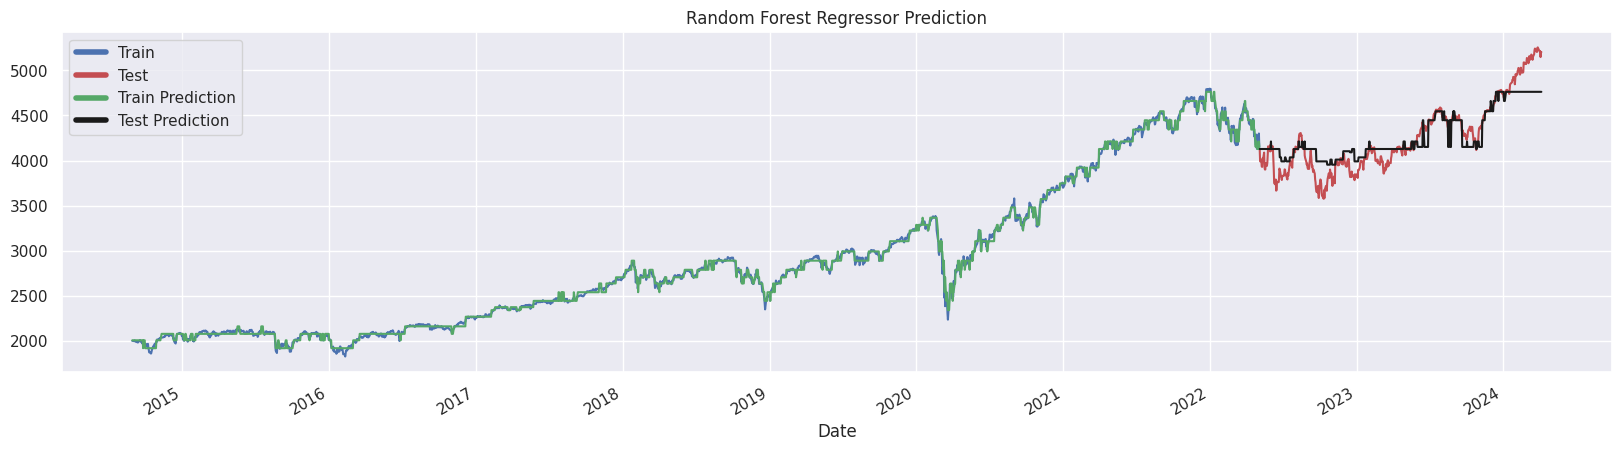

In [ ]:
# 4. Random Forest Regressor
reg = RandomForestRegressor(n_estimators=100, bootstrap=False, max_depth=5)
reg.fit(trainX, trainY)
predVal = reg.predict(valX)
predTrain = reg.predict(trainX)

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='k', lw=4)]

predTrain = predTrain.reshape(-1, 1)
predVal = predVal.reshape(-1, 1)

trainDf["Predicted"] = scY.inverse_transform(predTrain)
valDf["Predicted"] = scY.inverse_transform(predVal)

print("RMSE Train:", math.sqrt(mean_squared_error(trainDf["SP500_lagged"], trainDf["Predicted"])))
print("RMSE Test:", math.sqrt(mean_squared_error(valDf["SP500_lagged"], valDf["Predicted"])))
print("R2 Train:", r2_score(trainDf["SP500_lagged"], trainDf["Predicted"]))
print("R2 Test:", r2_score(valDf["SP500_lagged"], valDf["Predicted"]))
print()

ax = trainDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="SP500_lagged", ax=ax, legend=False, color="r")
trainDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="g")
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("Random Forest Regressor Prediction")

RMSE Train: 22.731778067400626
RMSE Test: 387.4648755334834
R2 Train: 0.9991875128005114
R2 Test: 0.04646351885564526



Text(0.5, 1.0, 'KNN Regression Prediction')

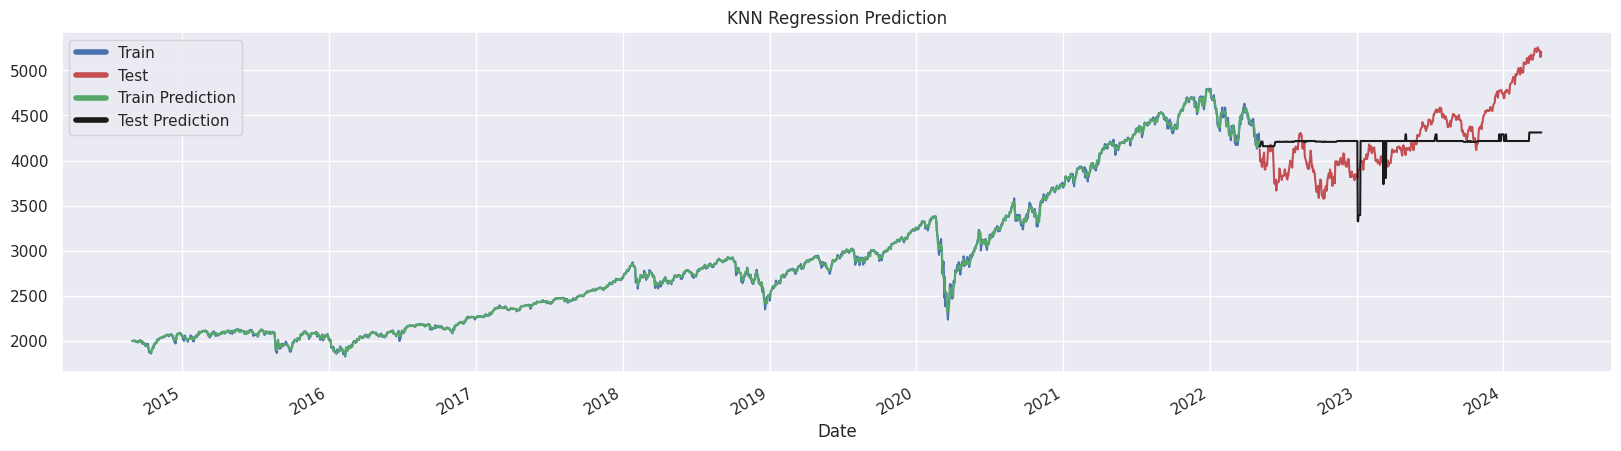

In [ ]:
# 5. KNN Regressor
reg = KNeighborsRegressor(n_neighbors=3).fit(trainX, trainY)
predVal = reg.predict(valX)
predTrain = reg.predict(trainX)

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='k', lw=4)]

predTrain = predTrain.reshape(-1, 1)
predVal = predVal.reshape(-1, 1)

trainDf["Predicted"] = scY.inverse_transform(predTrain)
valDf["Predicted"] = scY.inverse_transform(predVal)

print("RMSE Train:", math.sqrt(mean_squared_error(trainDf["SP500_lagged"], trainDf["Predicted"])))
print("RMSE Test:", math.sqrt(mean_squared_error(valDf["SP500_lagged"], valDf["Predicted"])))
print("R2 Train:", r2_score(trainDf["SP500_lagged"], trainDf["Predicted"]))
print("R2 Test:", r2_score(valDf["SP500_lagged"], valDf["Predicted"]))
print()

ax = trainDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="SP500_lagged", ax=ax, legend=False, color="r")
trainDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="g")
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("KNN Regression Prediction")

RMSE Train: 25.443714922081366
RMSE Test: 174.60903506574
R2 Train: 0.998982086779812
R2 Test: 0.8063551015686685



Text(0.5, 1.0, 'Gradient Boosting Regression Prediction')

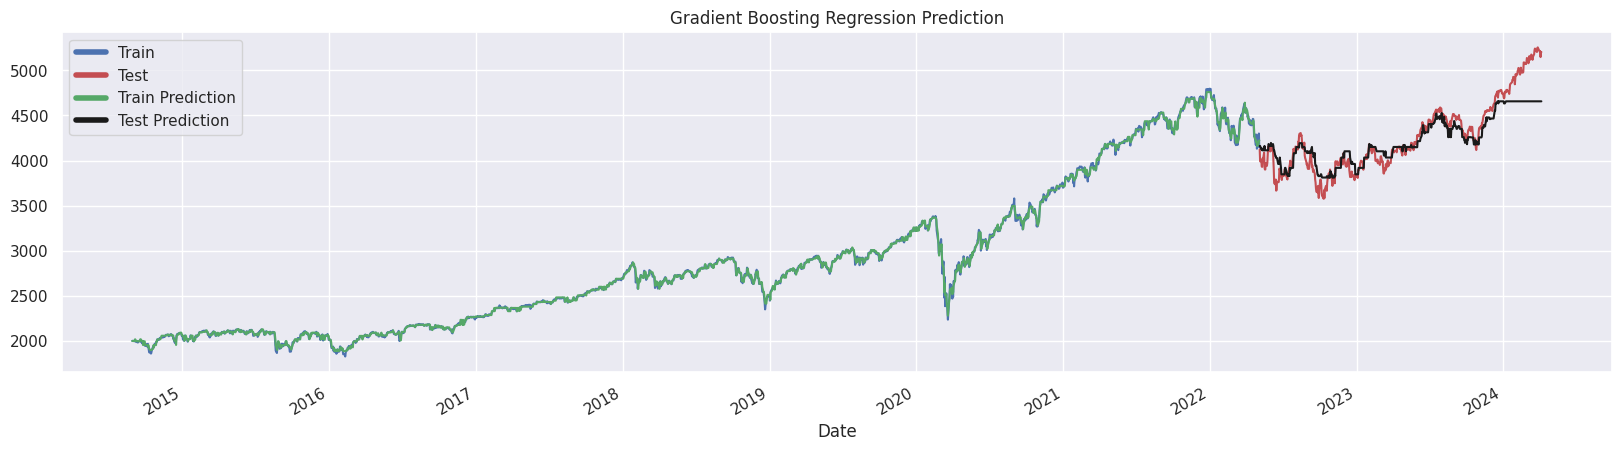

In [ ]:
# 6. Gradient Boosting Regressor
reg = xgboost.XGBRegressor(gamma=0.01,
                 max_depth=5,
                 n_estimators=1000).fit(trainX, trainY)
predVal = reg.predict(valX)
predTrain = reg.predict(trainX)

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='k', lw=4)]

predTrain = predTrain.reshape(-1, 1)
predVal = predVal.reshape(-1, 1)

trainDf["Predicted"] = scY.inverse_transform(predTrain)
valDf["Predicted"] = scY.inverse_transform(predVal)

print("RMSE Train:", math.sqrt(mean_squared_error(trainDf["SP500_lagged"], trainDf["Predicted"])))
print("RMSE Test:", math.sqrt(mean_squared_error(valDf["SP500_lagged"], valDf["Predicted"])))
print("R2 Train:", r2_score(trainDf["SP500_lagged"], trainDf["Predicted"]))
print("R2 Test:", r2_score(valDf["SP500_lagged"], valDf["Predicted"]))
print()

ax = trainDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="SP500_lagged", ax=ax, legend=False, color="r")
trainDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="g")
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("Gradient Boosting Regression Prediction")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE Train: 61.24635052753346
RMSE Test: 189.7651956136809
R2 Train: 0.9941019269922557
R2 Test: 0.7712791479136881



Text(0.5, 1.0, 'AdaBoost Regression Prediction')

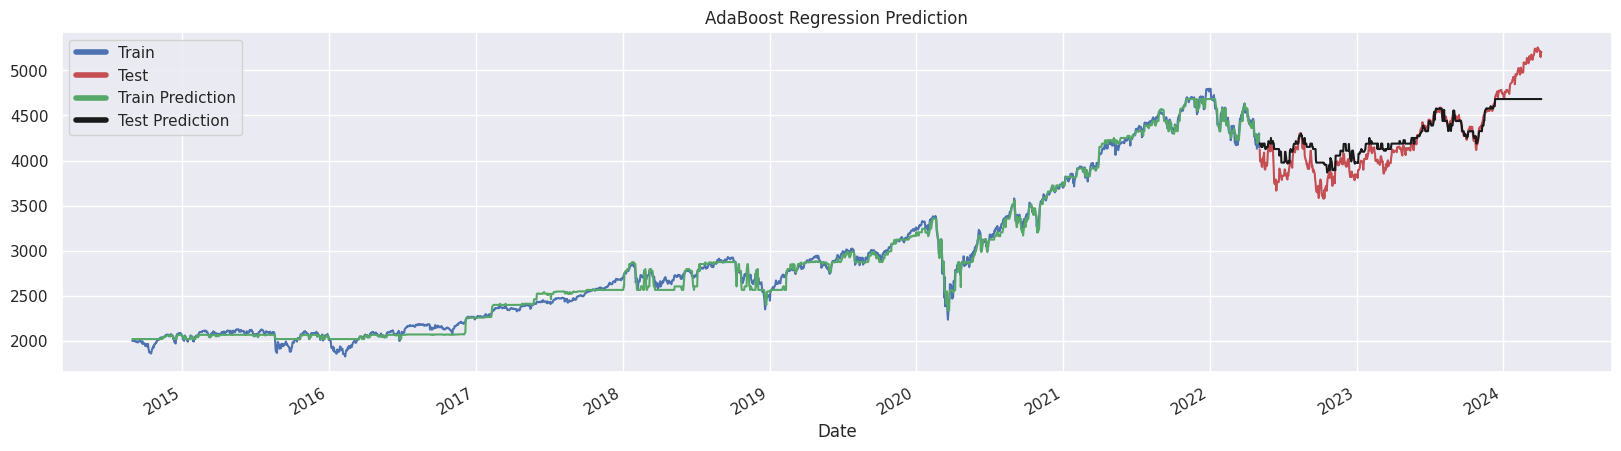

In [ ]:
# 7. AdaBoost Regressor
reg = AdaBoostRegressor(random_state=0, n_estimators=100, loss='linear').fit(trainX, trainY)
predVal = reg.predict(valX)
predTrain = reg.predict(trainX)

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='k', lw=4)]


predTrain = predTrain.reshape(-1, 1)
predVal = predVal.reshape(-1, 1)

trainDf["Predicted"] = scY.inverse_transform(predTrain)
valDf["Predicted"] = scY.inverse_transform(predVal)

print("RMSE Train:", math.sqrt(mean_squared_error(trainDf["SP500_lagged"], trainDf["Predicted"])))
print("RMSE Test:", math.sqrt(mean_squared_error(valDf["SP500_lagged"], valDf["Predicted"])))
print("R2 Train:", r2_score(trainDf["SP500_lagged"], trainDf["Predicted"]))
print("R2 Test:", r2_score(valDf["SP500_lagged"], valDf["Predicted"]))
print()

ax = trainDf.reset_index().plot(x="Date", y="SP500_lagged", legend=False, color="b", figsize=(20,5))
valDf.reset_index().plot(x="Date", y="SP500_lagged", ax=ax, legend=False, color="r")
trainDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="g")
valDf.reset_index().plot(x="Date", y="Predicted", ax=ax, legend=False, color="k")
ax.legend(custom_lines, ['Train', 'Test', 'Train Prediction', 'Test Prediction'])
ax.set_title("AdaBoost Regression Prediction")

#### LSTM Model

In [ ]:
# LSTM
TIME_STEPS = 30
BATCH_SIZE=30
lstmDf = modelDf
lstmDf.head()
df_train, df_test = train_test_split(lstmDf, train_size=0.6, test_size=0.4, shuffle=False)
print("Train Date Range: ", df_train.index[0].date(), ":",df_train.index[-1].date())
print("Test Date Range: ", df_test.index[0].date(), ":",df_test.index[-1].date())

Train Date Range:  2014-08-29 : 2020-06-03
Test Date Range:  2020-06-04 : 2024-04-05


In [ ]:
trainX, trainY = df_train.drop("SP500_lagged", axis=1).values, df_train[["SP500_lagged"]].values
testX, testY = df_test.drop("SP500_lagged", axis=1).values, df_test[["SP500_lagged"]].values

In [ ]:
# Normalizing
scX = MinMaxScaler()
scY = MinMaxScaler()
trainX = scX.fit_transform(trainX)
trainY = scY.fit_transform(trainY)
testX = scX.transform(testX)
testY = scY.transform(testY)

In [ ]:
def build_timeseries(matX, matY):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = matX.shape[0] - TIME_STEPS
    dim_1 = matX.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    for i in range(dim_0):
        x[i] = matX[i:TIME_STEPS+i]
        y[i] = matY[TIME_STEPS+i]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [ ]:
x_train, y_train = build_timeseries(trainX, trainY.reshape(trainY.shape[0],))
x_test, y_test = build_timeseries(testX, testY.reshape(testY.shape[0],))
x_train = trim_dataset(x_train, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)
x_test = trim_dataset(x_test, BATCH_SIZE)
y_test = trim_dataset(y_test, BATCH_SIZE)


length of time-series i/o (1470, 30, 10) (1470,)
length of time-series i/o (970, 30, 10) (970,)


Epoch 1/100
49/49 - 8s - loss: 0.0133 - val_loss: 0.4332 - 8s/epoch - 161ms/step
Epoch 2/100
49/49 - 2s - loss: 0.0203 - val_loss: 0.5554 - 2s/epoch - 37ms/step
Epoch 3/100
49/49 - 2s - loss: 0.0440 - val_loss: 0.5497 - 2s/epoch - 37ms/step
Epoch 4/100
49/49 - 2s - loss: 0.0367 - val_loss: 0.4946 - 2s/epoch - 41ms/step
Epoch 5/100
49/49 - 2s - loss: 0.0183 - val_loss: 0.4139 - 2s/epoch - 45ms/step
Epoch 6/100
49/49 - 3s - loss: 0.0108 - val_loss: 0.2855 - 3s/epoch - 54ms/step
Epoch 7/100
49/49 - 2s - loss: 0.0097 - val_loss: 0.2818 - 2s/epoch - 36ms/step
Epoch 8/100
49/49 - 2s - loss: 0.0096 - val_loss: 0.1839 - 2s/epoch - 37ms/step
Epoch 9/100
49/49 - 2s - loss: 0.0080 - val_loss: 0.1725 - 2s/epoch - 38ms/step
Epoch 10/100
49/49 - 2s - loss: 0.0064 - val_loss: 0.1243 - 2s/epoch - 37ms/step
Epoch 11/100
49/49 - 2s - loss: 0.0064 - val_loss: 0.1079 - 2s/epoch - 37ms/step
Epoch 12/100
49/49 - 2s - loss: 0.0054 - val_loss: 0.0874 - 2s/epoch - 43ms/step
Epoch 13/100
49/49 - 4s - loss: 0.00

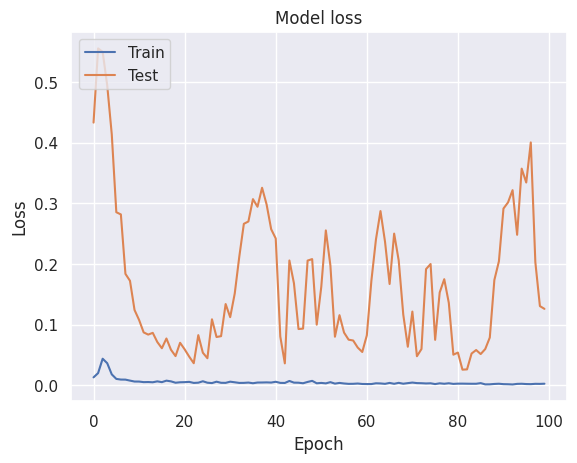

In [ ]:
#dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform',
model = keras.Sequential()
model.add(LSTM(units=100, return_sequences=True, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train.shape[2]), stateful=True))

model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(20,activation='relu'))
# Output layer
model.add(Dense(1,activation='relu'))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(x_train, y_train, epochs=100, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(x_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### The code is working in Google Colab but might failed in VS Code due to different syntax rule.
### The result has been provided in the report and you can also email us (sx274@cornell.edu or pj268@cornell.edu
### if you want the link to our Google Colab)


In [ ]:
y_pred_train = scY.inverse_transform(model.predict(x_train, batch_size=BATCH_SIZE))
print("Train Shape: ", y_pred_train.shape)
y_pred_test = scY.inverse_transform(model.predict(x_test, batch_size=BATCH_SIZE))
print("Test Shape: ", y_pred_test.shape)
y_train_orig = scY.inverse_transform(y_train.reshape(y_train.shape[0],1))
y_test_orig = scY.inverse_transform(y_test.reshape(y_test.shape[0],1))

49/49 [==============================] - 1s 12ms/step
Train Shape:  (1470, 1)
32/32 [==============================] - 0s 13ms/step
Test Shape:  (960, 1)


RMSE Train: 78.2448427457742
RMSE Test: 553.1075056217951
R2 Train: 0.9585880553121314
R2 Test: 0.9585880553121314



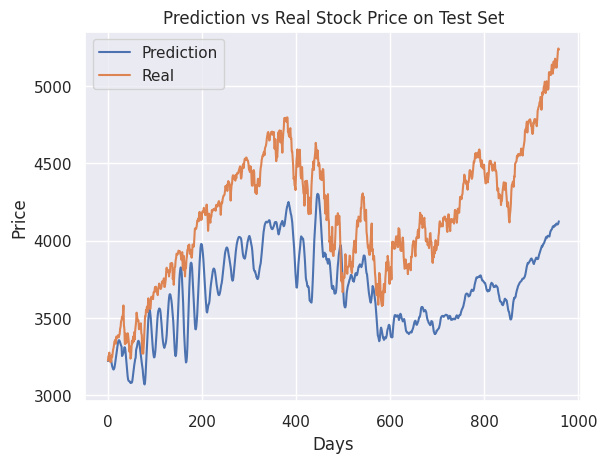

In [ ]:
print("RMSE Train:", math.sqrt(mean_squared_error(y_train_orig, y_pred_train)))
print("RMSE Test:", math.sqrt(mean_squared_error(y_test_orig, y_pred_test)))
print("R2 Train:", r2_score(y_train_orig, y_pred_train))
print("R2 Test:", r2_score(y_train_orig, y_pred_train))
print()
plt.figure()
plt.plot(y_pred_test)
plt.plot(y_test_orig)
plt.title('Prediction vs Real Stock Price on Test Set')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()


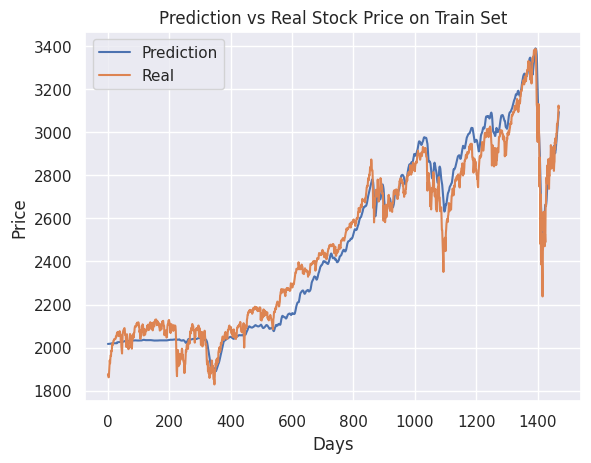

In [ ]:
plt.figure()
plt.plot(y_pred_train)
plt.plot(y_train_orig)
plt.title('Prediction vs Real Stock Price on Train Set')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()